In [8]:
import pandas as pd
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt

In [22]:
import os
print(os.getcwd())
df = pd.read_csv("./input/demo.csv")
# df_all = pd.read_csv("./input/demo.csv")
df_all = pd.read_csv("./output/baseline_bounds.csv")
print(df)
print(df_all)

/home/ahmad/python data/UvoCorps Data/Pending Orders/jan 20 2024 1954/provided data/556681954_task_940588434950938 (2)/task
               tag        date  \
0             AIF/  2022-12-01   
1             AIF/  2022-12-02   
2             AIF/  2022-12-03   
3             AIF/  2022-12-04   
4             AIF/  2022-12-05   
..             ...         ...   
88  kommersant.ru/  2022-12-27   
89  kommersant.ru/  2022-12-28   
90  kommersant.ru/  2022-12-29   
91  kommersant.ru/  2022-12-30   
92  kommersant.ru/  2022-12-31   

                                                 demo  \
0   {'Men above 45': 270578.0, 'Men 25-34': 248189...   
1   {'Men above 45': 242880.0, 'Men 25-34': 218607...   
2   {'Men above 45': 215736.0, 'Men 25-34': 195687...   
3   {'Men above 45': 205517.0, 'Men 25-34': 181038...   
4   {'Men above 45': 215976.0, 'Men 25-34': 207819...   
..                                                ...   
88  {'Men 25-34': 327395.0, 'Men 18-24': 273582.0,...   
89  {'Men 2

In [10]:
def columns_to_dict(row, col):
    
    """Turns one column of strings into the column of dictionaries"""
    return ast.literal_eval(row[col])
    

def str_to_dict(df1):
    """Preprocessing the data: turning str columns to dict columns"""
    
    columns_list = ['demo', 'visitors_country', 'pageviews_country',
       'visitors_region', 'pageviews_region', 'providers', 'languages',
       'browsers', 'oses', 'resolutions', 'colors']
    
    for one_column in tqdm(columns_list):
        df1[one_column] = df1.apply(lambda x: columns_to_dict(x, one_column), axis = 1)
    return df1


def get_bounds(df1, feature, tag1, tag2, date):
    """For one feature and two websites estimates the lower and upper bounds of total audience"""
    
    dict1 = df1.loc[(df1["tag"] == tag1) &
                    (df1["date"] == date)][feature].values
    if len(dict1) == 0:
        dict1 = {}
    elif len(dict1) > 1:
        raise ValueError(f"MORE THAN ONE OBSERVATION {tag1}  {date}")
    else:
        dict1 = dict1[0]
        
    dict2 = df1.loc[(df1["tag"] == tag2) &
                    (df1["date"] == date)][feature].values
    if len(dict2) == 0:
        dict2 = {}
    elif len(dict2) > 1:
        raise ValueError(f"MORE THAN ONE OBSERVATION {tag2}  {date}")
    else:
        dict2 = dict2[0]
        
        
    all_keys = list(set(dict1.keys()) | set(dict2.keys()))
    
    sum_of_max = 0
    sum_of_all = 0
    for one_key in all_keys:
        first_val = dict1.get(one_key, 0)
        second_val = dict2.get(one_key, 0)
        
        sum_of_max += max([first_val, second_val])
        
        sum_of_all += first_val
        sum_of_all += second_val
        
    return sum_of_max, sum_of_all

def get_final_bounds(df1):
    
    """Turns lower and upper bounds of single features into shares (lower/upper), 
    then finds max share, then turns it back to number of visitors.
    In reality all upper bounds are same (just sum of both websites' visitors), 
    but we have a lack of data, so we need this transition into shares"""
    
    bounds_columns = ['demo', 
       'visitors_country', 
       'visitors_region',  'providers',
        # 'languages', ## commented out since missing for one of the websites
       'browsers', 'oses', 
       'resolutions', 'colors']
    
    shares_df = pd.DataFrame()
    for one_column in bounds_columns:
        shares_df[one_column + "_share"] = df1[one_column + "_lower"] / df1[one_column + "_upper"]
        
    max_shares = shares_df.max(axis = 1)
    upper_bound = (df1["visitors1"] + df1["visitors2"])
    lower_bound = max_shares * upper_bound
    
    df1["lower_bound"] = lower_bound
    df1["upper_bound"] = upper_bound
        
    return df1

In [11]:
df_proc = str_to_dict(df)

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 46.48it/s]


In [13]:
# example for one single feature

one_feature = "visitors_country"

first_tag = 'RBCRU/'
second_tag = 'AIF/'

one_date = '2022-12-18'


print(df_proc.loc[(df_proc["tag"] == first_tag) &
                    (df_proc["date"] == one_date)][one_feature].values[0])
print()
print(df_proc.loc[(df_proc["tag"] == second_tag) &
                    (df_proc["date"] == one_date)][one_feature].values[0])
print()
a, b = get_bounds(df_proc, one_feature, first_tag, second_tag, one_date)
print(f"The lower bound of total audience (with max possible overlap) using one single feature #{one_feature} is {a}")
print(f"The upper bound of total audience (with no overlap) is {b}")

{'Russia': 1372728.0, 'Belarus': 46171.0, 'Kazakhstan': 41544.0, 'Germany': 28042.0, 'USA': 17775.0, 'Crimea': 15638.0, 'Ukraine': 11155.0, 'The Netherlands': 10084.0, 'Great Britain': 9131.0, 'France': 8682.0, 'Uzbekistan': 8638.0, 'Turkey': 8374.0, 'Others': 7866.0, 'Poland': 7511.0, 'Kyrgyzstan': 7412.0, 'Moldova': 6798.0, 'Israel': 6206.0, 'Spain': 5532.0, 'Georgia': 5170.0, 'Armenia': 4909.0, 'Thailand': 4834.0, 'UAE': 4710.0, 'Azerbaijan': 3864.0, 'Estonia': 3778.0, 'Finland': 3574.0, 'Italy': 3562.0, 'Czechia': 3246.0, 'Canada': 3044.0, 'Sweden': 2838.0, 'Latvia': 2828.0, 'Switzerland': 2633.0, 'Turkmenistan': 2348.0, 'Lithuania': 2338.0, 'Romania': 2238.0, 'Tajikistan': 2122.0, 'Austria': 1990.0, 'Serbia': 1801.0, 'Hong-Kong': 1665.0, 'Cyprus': 1611.0, 'Bulgaria': 1575.0, 'Egypt': 1360.0, 'Belgium': 1242.0, 'Indonesia': 1121.0, 'Portugal': 1035.0, 'Greece': 1000.0, 'Norway': 991.0, 'South Korea': 842.0, 'India': 839.0, 'Australia': 786.0, 'Hungary': 764.0, 'Ireland': 756.0, 'De

In [14]:
visitors_columns = ['demo', 'visitors_country', 
       'visitors_region', 'providers', 'languages',
       'browsers', 'oses', 'resolutions', 'colors']
all_tags = df_proc["tag"].unique().tolist()
all_dates = df_proc["date"].unique().tolist()

# prepare headers to dataframe
headers =  ["tag1", "tag2", "date"]
for col in visitors_columns:
    headers.append(col+"_lower")
    headers.append(col+"_upper")

# find upper and lower bounds for all features and all pairs of websites
final_list = []
for first_tag in tqdm(all_tags):
    
    for second_tag in all_tags:
        dates1 = df_proc.loc[df_proc["tag"] == first_tag]["date"].unique().tolist()
        dates2 = df_proc.loc[df_proc["tag"] == second_tag]["date"].unique().tolist()
        both_dates = list(set(dates1) & set(dates2))
        for one_date in both_dates:
            one_day_list = [first_tag, second_tag, one_date]
            for one_feature in visitors_columns:
                
                sum_max, sum_all = get_bounds(df_proc, one_feature, first_tag, second_tag, one_date)
                one_day_list.append(sum_max)
                one_day_list.append(sum_all)
            final_list.append(one_day_list)
    
final_df = pd.DataFrame(final_list, columns = headers)

100%|█████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


In [15]:
# Add all visitors number
df_all = df_all.rename(columns = {"tag": "tag1", "Visitors":"visitors1"})
final_df = df_all.merge(final_df, how = "left", on = ["tag1", "date"])
df_all = df_all.rename(columns = {"tag1": "tag2", "visitors1":"visitors2"})
final_df = df_all.merge(final_df, how = "left", on = ["tag2", "date"])

In [16]:
# calculate final lower and upper bounds
df2 = get_final_bounds(final_df)

In [17]:
final_output = df2[["tag2", "tag1", "date", "lower_bound", "upper_bound", "visitors1", "visitors2"]]

/var/folders/qg/qg3xz86n5b79v5qhrks86fch0000gn/T/ipykernel_96906/2369680708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_output.loc[:, 'naive_lower_bound'] = final_output['visitors1'] * (final_output['visitors1'] > final_output['visitors2']) + final_output['visitors2'] * (final_output['visitors2'] >= final_output['visitors1'])
/var/folders/qg/qg3xz86n5b79v5qhrks86fch0000gn/T/ipykernel_96906/2369680708.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_output.loc[:, 'delta_tighter'] = (fi

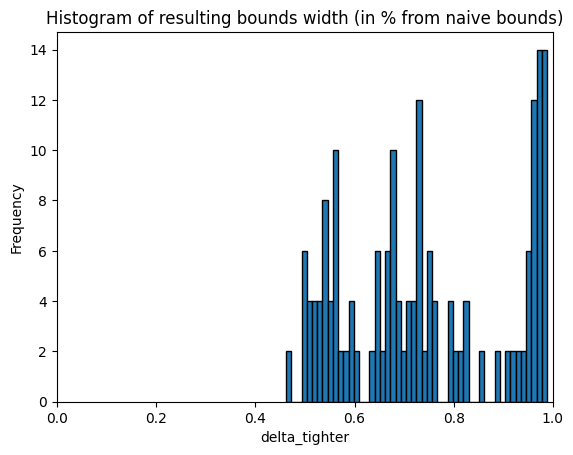

0.7438641483759236

In [10]:
# compare new lower bound with a naive lower bound 
final_output.loc[:, 'naive_lower_bound'] = final_output['visitors1'] * (final_output['visitors1'] > final_output['visitors2']) + final_output['visitors2'] * (final_output['visitors2'] >= final_output['visitors1'])
final_output.loc[:, 'delta_tighter'] = (final_output['upper_bound'] - final_output['lower_bound']) / (final_output['upper_bound'] - final_output['naive_lower_bound'])
# histogram of how much tighter the bounds are; exclude when the same website 

filtered_data = final_output[final_output['tag1'] != final_output['tag2']]
plt.hist(filtered_data['delta_tighter'], bins=50, edgecolor='black')
plt.title('Histogram of resulting bounds width (in % from naive bounds)')
plt.xlabel('delta_tighter')
plt.ylabel('Frequency')
plt.xlim(0, 1)
plt.show()
filtered_data['delta_tighter'].mean()

In [18]:
final_output

,tag2,tag1,date,lower_bound,upper_bound,visitors1,visitors2
0,AIF/,AIF/,2022-12-01,1387448.0,2774896.0,1387448.0,1387448.0
1,AIF/,RBCRU/,2022-12-01,2444691.0,3379425.0,1991977.0,1387448.0
2,AIF/,kommersant.ru/,2022-12-01,1680866.0,2644070.0,1256622.0,1387448.0
3,AIF/,AIF/,2022-12-02,1224443.0,2448886.0,1224443.0,1224443.0
4,AIF/,RBCRU/,2022-12-02,2275840.0,3091232.0,1866789.0,1224443.0
...,...,...,...,...,...,...,...
274,kommersant.ru/,RBCRU/,2022-12-30,1966159.0,3186951.0,1913593.0,1273358.0
275,kommersant.ru/,kommersant.ru/,2022-12-30,1273358.0,2546716.0,1273358.0,1273358.0
276,kommersant.ru/,AIF/,2022-12-31,1766876.0,2494229.0,1419916.0,1074313.0
277,kommersant.ru/,RBCRU/,2022-12-31,1487167.0,2441468.0,1367155.0,1074313.0


In [19]:
final_output.to_csv("./output/baseline_bounds.csv", index = False)